In [2]:
from __future__ import print_function, division, absolute_import

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=20"

import jax.numpy as np
from numpy.random import choice
import numpy as onp
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev, hessian, pmap
from jax import random
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers
from jax.tree_util import tree_map
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools
from matplotlib import animation
from IPython.display import HTML
from IPython.display import display, Image
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import json
from scipy.integrate import solve_ivp
from scipy import integrate

import tapsap

from collections import OrderedDict

import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled
from mpl_toolkits.axes_grid1.axes_divider import Divider, Size
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from jax.nn import swish, tanh

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

left  = 0.05  # the left side of the subplots of the figure
right = 0.925    # the right side of the subplots of the figure
bottom = 0.15   # the bottom of the subplots of the figure
top = 0.85      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.25   # the amount of height reserved for white space between subplots

## 1 Read and preprocess

### 1.1 Read outlet flux

In [2]:
onp.random.seed(0)

# Read of outlet flux data used to estimate thin zone concentration and flux
f = open('../../data/TAP_experimental_data.json')
experimental_data = json.load(f)
f.close()
experimental_data = json.loads(experimental_data)['1']

n_species = 0

y_total = []
t_total = []

for j, k in enumerate(experimental_data):
    if k == 'time':
        for i in experimental_data[k].keys():
            t_temp = [experimental_data[k][i][0]]+experimental_data[k][i][10:]
            t_total.extend(np.array(t_temp)+2.5*(int(i)))
        t_total = onp.array([t_total]).T
        
    else:
        y_temp = []
        for i in experimental_data[k].keys():
            experimental_data_temp = [experimental_data[k][i][0]] + experimental_data[k][i][10:]
            experimental_data_temp = list(np.array(experimental_data_temp)
            y_temp += experimental_data_temp
        y_total.append(onp.array(y_temp))
        
y_total_noise = onp.array(y_total)

out_flux_total = onp.array(y_total_noise).reshape(-1, 10, len(t_temp))

In [5]:
# Read the ground truth data as reference

f = open('../../data/TAP_thin_data.json')
thin_data = json.load(f)
f.close()
thin_data = json.loads(thin_data)['1']

y_total = []

for j, k in enumerate(thin_data):
    if k == 'time':
        pass
        
    else:
        y_temp = []
        for i in thin_data[k].keys():
            y_temp += [thin_data[k][i][0]]+thin_data[k][i][10:]
        y_total.append(onp.array(y_temp))
        
conc_true = onp.array(y_total).reshape(-1, 10, len(t_temp))

### 1.2 Y-Proc estimated rate

In [7]:
def y_rate(out_flux_all, t, zone_lengths, zone_porosity, pulse_series, n = 0):
    '''
    Estimate reaction rate based on outlet flux using Y-procedure
    '''
    
    t = t.flatten()
    estimate_y_rate = []
    
    for j in range(3):
        estimate_y_rate_temp = []
        for i in range(len(pulse_series)):
            out_flux = out_flux_all[:, i, :]
            
            out_flux = tapsap.baseline_correction(out_flux.T, t, [t[-1]-0.5, t[-1]])['flux'].T
            
            inert_flux = out_flux[-1]
            inert_moments = tapsap.moments(inert_flux, t)

            out_flux = out_flux/inert_moments['M0']
            
            diffusion = tapsap.diffusion_moments(inert_moments, zone_lengths, zone_porosity, 40., mass[j])['diffusion']
            
            if j != 2:
                inert_graham = tapsap.grahams_law(inert_flux, t, float(40), mass[j])
                estimate_y_rate_temp.append(tapsap.rate_y(onp.array(out_flux[j, :])[n:],onp.array(t)[n:],diffusion,zone_lengths,zone_porosity,inert_flux = inert_graham[n:], smoothing_amt= 3)*inert_moments['M0'])
            else:
                estimate_y_rate_temp.append(-tapsap.rate_y(onp.array(out_flux[j, n:]),onp.array(t)[n:],diffusion,zone_lengths,zone_porosity,inert_flux = None, smoothing_amt= 3)*inert_moments['M0'])
                
        estimate_y_rate.append(estimate_y_rate_temp)
    return onp.array(estimate_y_rate)

In [8]:
zone_lengths = {'zone0': 2.80718, 'zone1': 0.17364, 'zone2': 2.80718}
zone_porosity = {'zone0':0.4, 'zone1':0.4, 'zone2':0.4}

radius = 1
cross_sec_area = radius**2 * onp.pi
V_cat = zone_lengths['zone1'] * cross_sec_area

nt = 30

mass = np.array([28.01, 32, 44.01])

In [9]:
estimate_y_rate = y_rate(out_flux_total, t_total[:len(t_temp)], zone_lengths, zone_porosity, np.linspace(0,9,10), n = 0)
net_flux_gas = np.array(estimate_y_rate)/cross_sec_area/zone_lengths['zone1']
estimate_y_rate.shape  #CO O2 CO    #1/s

(3, 10, 2501)

### 1.3 Estimate uptake as integral of rate

In [12]:
estimate_rate = estimate_y_rate.reshape(-1, len(t_total))
gas_uptake = integrate.cumtrapz(np.array(estimate_rate), t_total.flatten(), initial = 0)
gas_uptake.shape

(3, 25010)

In [13]:
# Convert gas uptake to atomic uptake
atom_uptake = []
atom_uptake.append(gas_uptake[0] + gas_uptake[-1])                       # C = CO - CO2
atom_uptake.append(gas_uptake[1]*2 + gas_uptake[0] + gas_uptake[-1]*2)   # O = 2*O2 + CO - 2*CO2
atom_uptake = np.array(atom_uptake)/V_cat
atom_uptake = atom_uptake.reshape(2, 10, -1)
atom_uptake.shape

(2, 10, 2501)

### 1.4 Estimate concentration

In [14]:
def y_conc(out_flux_all, t, zone_lengths, zone_porosity, pulse_series, n = 0):
    '''
    Estimate thin zone concentrations of each gas species using Y-procedure
    '''
    
    t = t.flatten()
    estimate_y_conc = []
    
    for j in range(3):
        estimate_y_conc_temp = []

        for i in range(len(pulse_series)):
            out_flux = out_flux_all[:, i, :]
            out_flux = tapsap.baseline_correction(out_flux.T, t, [t[-1]-0.3, t[-1]])['flux'].T
            
            inert_flux = out_flux[-1]
            inert_moments = tapsap.moments(inert_flux, t)
            
            out_flux = out_flux/inert_moments['M0']
            
            diffusion = tapsap.diffusion_moments(inert_moments, zone_lengths, zone_porosity, float(40), mass[j])
            concentration_units = tapsap.concentration_units(diffusion['diffusion'], zone_lengths, 1, inert_moments['M0'])

            estimate_y_conc_temp.append(tapsap.concentration_y(onp.array(out_flux[j, :])[n:], onp.array(t)[n:], 
                                                               diffusion['diffusion'], zone_lengths, zone_porosity, smoothing_amt = 6)*concentration_units)

        estimate_y_conc.append(estimate_y_conc_temp)
    return onp.array(estimate_y_conc)

In [15]:
estimate_y_conc = y_conc(out_flux_total, t_total[:len(t_temp)], zone_lengths, zone_porosity, np.linspace(0, 9, 10), n = 0)
estimate_y_conc = np.array(estimate_y_conc)
estimate_y_conc.shape 

(3, 10, 2501)

## 2. PreProcess the data

### 2.1 Read moments

In [16]:
f = open('../../data/TAP_moments.json')
moments_data = json.load(f)
f.close()
moments_data = json.loads(moments_data)['1']

# Pulse use to train and test the interpolation
pulse_train = [0, 1, 2, 5, 8]
pulse_test = [3, 4, 6, 7, 9]

pulse_train = [str(p) for p in pulse_train]
pulse_test = [str(p) for p in pulse_test]

n_pulse = 0
n_gas = 0
n_species = 6

# Use 0th moment as additional input for multi-pulse fitting
moments_train = []
moments_test = []
for j, k in enumerate(moments_data):
    for i in moments_data[k].keys():
        if i in pulse_train:
            moments_train.append(np.array(moments_data[k][i]['M0']))
        elif i in pulse_test:
            moments_test.append(np.array(moments_data[k][i]['M0']))
        else:
            print('pulse', i, 'not specified')
    n_pulse = int(i) + 1
n_gas = j + 1 - 1

moments_train = np.array(moments_train).reshape(-1, len(pulse_train)).T[:,:-1]  #eliminate inert
moments_test = np.array(moments_test).reshape(-1, len(pulse_test)).T[:,:-1]

n_latent = n_species - n_gas

moments_train.shape
# row--pulse,   column--species

(5, 3)

### 2.2 Subsampling

In [18]:
t_train = []
t_test = []

for i in range(10):
    t_1 = t_temp[4:40:1]+t_temp[40:100:3]+t_temp[100:300:5]+t_temp[300:-100:60]

    if str(i) in pulse_train:
        t_train.extend(np.array(t_1))
    elif str(i) in pulse_test:
        t_test.extend(np.array(t_1))
        
t_train = np.log(np.array([t_train]).T)
t_test = np.log(np.array([t_test]).T)
    
moment_t = []
for n in range(len(pulse_train)):
    moment_t.extend(np.broadcast_to(moments_train[n], (len(t_1), len(moments_train[n]))))
t_input = np.concatenate((t_train, np.array(moment_t)), axis = 1)
        
moment_t = []
for n in range(len(pulse_test)):
    moment_t.extend(np.broadcast_to(moments_test[n], (len(t_1), len(moments_test[n]))))
t_input_test = np.concatenate((t_test, np.array(moment_t)), axis = 1)    

n_p = int(len(t_input)/len(pulse_train))

In [20]:
y_train = []
y_train_smooth = []
y_test = []
y_test_smooth = []

# Subsampling and add noise based on the standard deviation
for j in range(n_gas):
    y_temp_train = []
    y_temp_train_smooth = []
    y_temp_test = []
    y_temp_test_smooth = []

    for i in range(10):
        
        y_temp = estimate_y_conc[j,i,:]
        y_temp_i = []
        if str(i) in pulse_train:
            y_temp_i = list(np.concatenate([y_temp[4:40:1], y_temp[40:100:3], y_temp[100:300:5], y_temp[300:-100:60]], axis = 0))
            noise = np.std(np.array(y_temp_i)) * 0.5
            y_temp_i_noise = list(np.array(y_temp_i) + onp.random.normal(0.0, noise, np.array(y_temp_i).shape))

            y_temp_train += y_temp_i_noise
            y_temp_train_smooth += y_temp_i
            
        elif str(i) in pulse_test:
            y_temp_i = list(np.concatenate([y_temp[4:40:1], y_temp[40:100:3], y_temp[100:300:5], y_temp[300:-100:60]], axis = 0))
            noise = np.std(np.array(y_temp_i)) * 0.5
            y_temp_i_noise = list(np.array(y_temp_i) + onp.random.normal(0.0, noise, np.array(y_temp_i).shape))

            y_temp_test += y_temp_i_noise 
            y_temp_test_smooth += y_temp_i
            
    y_train.append(np.array(y_temp_train))
    y_test.append(np.array(y_temp_test))

    y_train_smooth.append(np.array(y_temp_train_smooth))
    y_test_smooth.append(np.array(y_temp_test_smooth))

total_species = int(j) - 1

# Scale into range 0 to 1
y_train = onp.array(y_train)
y_train_scale = np.max(y_train, axis = 1)

y_test = onp.array(y_test)
y_test_scale = np.max(y_test, axis = 1)

conc_inv = (y_train.T/y_train_scale, t_input)
conc_inv_test = (y_test.T/y_test_scale, t_input_test)

In [23]:
net_flux_train = []
net_flux_test = []

for j in range(n_species):
    f_temp_train = []
    f_temp_test = []

    if j < n_gas:
        for i in range(10):
        
            f_temp = net_flux_gas[j,i,:]
            f_temp_i = []
            if str(i) in pulse_train:
                f_temp_i = np.concatenate([f_temp[4:40:1], f_temp[40:100:3], f_temp[100:300:5], f_temp[300:-100:60]], axis = 0)
                f_temp_i = list(np.array(f_temp_i)
                f_temp_train += f_temp_i
                
            elif str(i) in pulse_test:
                f_temp_i = np.concatenate([f_temp[4:40:1], f_temp[40:100:3], f_temp[100:300:5], f_temp[300:-100:60]], axis = 0)
                f_temp_i = list(np.array(f_temp_i)
                f_temp_test += f_temp_i
    else:
        f_temp_train.extend(np.zeros(net_flux_train[0].shape))
        f_temp_test.extend(np.zeros(net_flux_test[0].shape))
            
    net_flux_train.append(np.array(f_temp_train))
    net_flux_test.append(np.array(f_temp_test))

net_flux_train = np.array(net_flux_train).T[:,:]
net_flux_test = np.array(net_flux_test).T

In [26]:
uptake_train = []
uptake_test = []

# Noise is also added to the atomic uptake
for j in range(len(atom_uptake)):
    u_temp_train = []
    u_temp_test = []

    for i in range(10):
        
        u_temp = atom_uptake[j,i,:]
        u_temp_i = []
        if str(i) in pulse_train:
            u_temp_i = np.concatenate([u_temp[4:40:1], u_temp[40:100:3], u_temp[100:300:5], u_temp[300:-100:60]], axis = 0)
            noise = np.std(np.array(u_temp_i)) * 0.5
            u_temp_i = list(np.array(u_temp_i) + onp.random.normal(0.0, noise, np.array(u_temp_i).shape))
            u_temp_train += u_temp_i
            
        elif str(i) in pulse_test:
            u_temp_i = np.concatenate([u_temp[4:40:1], u_temp[40:100:3], u_temp[100:300:5], u_temp[300:-100:60]], axis = 0)
            noise = np.std(np.array(u_temp_i)) * 0.5
            u_temp_i = list(np.array(u_temp_i) + onp.random.normal(0.0, noise, np.array(u_temp_i).shape))
            u_temp_test += u_temp_i
            
    uptake_train.append(np.array(u_temp_train))
    uptake_test.append(np.array(u_temp_test))

# Scale into range 0 to 1
uptake_train = np.array(uptake_train)
uptake_train_scale = np.max(uptake_train)
uptake_train = uptake_train.T/uptake_train_scale

uptake_test = np.array(uptake_test)
uptake_test_scale = np.max(uptake_test)
uptake_test = uptake_test.T/uptake_test_scale

In [30]:
data_scale = np.concatenate([y_train_scale, np.array([uptake_train_scale]*3)])
data_test_scale = np.concatenate([y_test_scale, np.array([uptake_test_scale]*3)])

data_inv = (np.concatenate((conc_inv[0], net_flux_train, uptake_train), axis = -1), conc_inv[-1])
data_inv_test = (np.concatenate((conc_inv_test[0], net_flux_test, uptake_test), axis = -1), conc_inv_test[-1])

## 3. Define the NN

In [31]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    return (scale * random.normal(key, (m,)))

def init_network_params(sizes, key, scale):
    '''
    Initialize all layers for a fully-connected neural network with sizes "sizes"
    '''
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def init_model_params(size, key, scale):
    '''
    Initialize kinetic model with size "size"
    '''
    key = random.split(key,2)[-1] 
    return [random_model_params(s, key, scale) for s in size]

@jit
def act_fun(x):
    return swish(x)
    
@jit
def state(params, t):
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = act_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    # Absolute function at output layer to guarantee nonnegative concentration
    y = np.abs(y)
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))

@jit
def diff_state(params,t):
    '''
    Backpropogation through jacobian
    '''
    i = np.arange(len(t))
    return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])
    
def loss(get_errors, params, batch, flux, uptake):
    return np.array([_.sum() for _ in get_errors(params,batch,flux,uptake)]).sum()

def train(params,data,ferrors,loss,num_epochs,num_iter,opt_objs,err_tags,batch_size=None):
    opt_state, opt_update, get_params, iter_data = opt_objs

    @jit
    def step(data, params):
        batch_conc = data[0][:,:n_gas]
        batch = [batch_conc, data[1]]
        flux = data[0][:,n_gas:-2]          # 2 elements
        uptake = data[0][:, -2:]      
        grads = grad(lambda ferrors, params, batch, flux, uptake :np.nan_to_num(loss(ferrors, params, batch, flux, uptake))\
                     ,argnums=1)(ferrors, params, batch, flux, uptake)
        return grads
    
    step_parallel = pmap(step, in_axes = (0, None))
    
    def mean_map(grad):
        return tree_map(lambda x: x.mean(axis = 0), grad)
    
    mean_fn = jit(mean_map)
    
    @jit
    def update(itercount, grads, opt_state):
        return opt_update(itercount, grads, opt_state)
    
    itercount = itertools.count()        
    if not batch_size:
        batch_size = data[0].shape[0]
    
    # Use 20 processors, change with number of processor used
    # Reshape the data for distribution over processors
    data_parallel = (data[0].reshape(20,-1,n_gas+n_gas+n_latent+2), data_inv[1].reshape(20,-1,1+n_gas))
    iter_data += [get_params(opt_state).copy()]
    
    for j in range(num_epochs):
        clear_output(wait=True)
        
        for i in range(int(num_iter)):
            params = get_params(opt_state)
            
            grads_parallel = step_parallel(data_parallel, params)
            grads = mean_fn(grads_parallel)
            
            opt_state = update(next(itercount), grads, opt_state)
    
        batch_conc = data[0][:,:n_gas]
        batch = [batch_conc, data[1]]   # [x, t]
        flux = data[0][:,n_gas:-2]      # flux of adspecies is 0
        uptake = data[0][:,-2:]         # 2 elements
        
        params = get_params(opt_state)
        loss_it_batch = loss(ferrors, params, batch, flux, uptake)
        errs = [_.sum() for _ in ferrors(params,batch,flux,uptake)]
        print('Epoch: {:4d}, Loss Batch: {:.5e}'.format(j,loss_it_batch)+\
                  ''.join([', Fit {}: {:.5e}'.format(_,__) for _,__ in zip(err_tags,errs)]))
        print(params[-1])
        iter_data += [params.copy()]
    
    return params, [opt_state, opt_update, get_params, iter_data], err_epoch

In [32]:

def errors_inv(params, batch, flux, uptake):
    x, t = batch
    NA = np.array(flux)
    uptake = np.array(uptake)
    nn_params, model_params = params
    
    pred_x = batched_state(nn_params,t)
    # data loss
    err_data = ((pred_x[:,:-n_latent]-x)**2).sum(axis=1)
    # atomic uptake loss
    err_U = ((pred_x[:,-3] - uptake[:,0])**2).sum() + ((pred_x[:,-3] + pred_x[:,-2] - uptake[:,1])**2).sum()
    # vacant site loss
    err_nt = ((pred_x[:,-1] + pred_x[:,-2] + pred_x[:,-3] - nt/uptake_train_scale)**2).sum()
    # model loss, 0th moment should not be part of the chain rule
    err_model = ((diff_state(nn_params,t) / np.exp(t[:,0:1]) - batched_model([pred_x,t],model_params,NA) / data_scale)**2).sum(axis=1)
    
    # Total loss as the combine of 4 terms
    return [1e3*err_data, 1e3*err_U, 1e3*err_nt, err_model]


In [33]:
@jit
def model(batch, model_params, flux):
    '''
    Define the ODE kinetic model
    '''
    x, t = batch
    k, = model_params
    k, x = [np.abs(_) for _ in [k,x]]
    x = x * data_scale
    return np.array(np.array([[-k[0]*x[0]*x[5] + k[1]*x[3] - k[5]*x[0]*x[4]],
                    [-k[2]*x[1]*x[5]**2],
                    [k[3]*x[3]*x[4] - k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]],
                    [k[0]*x[0]*x[5] - k[1]*x[3] - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2],
                    [(k[2]*x[1]*x[5]**2)*2 - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2 - k[5]*x[0]*x[4]],
                    [-k[0]*x[0]*x[5] + k[1]*x[3] - (k[2]*x[1]*x[5]**2)*2 + k[3]*x[3]*x[4]*2 - 2*k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]]]) + 
                    onp.reshape(flux, (6,1)))

batched_model = lambda batch, model_params, flux : vmap(model,in_axes=(0,None,0))(batch,model_params,flux)[:,:,0]#, in_axes=(None, 0)

In [35]:
layer_sizes = [1+n_species-n_latent, 10, 10, 6] # inputs, hidden..., output layes
model_size = [6]
key = random.PRNGKey(0)

nn_scale = 0.01 # weights scales
model_scale = 0.00001 # model scale (assume low so as not to eb bias)

# nn_params = init_network_params(layer_sizes, key, nn_scale)
nn_params = nn_params_inv
# model_params = init_model_params(model_size, key, model_scale)
model_params_inv = [np.array([-6.35536503,  0.6937773 , -0.13582364,  0.43858398,  0.02428112,
         5.7058429 ])]
params = [nn_params, model_params_inv] #pack

opt_inv = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
opt_inv = (opt_inv[0](params), opt_inv[1], opt_inv[2], [])

In [ ]:
%%time
err_tags = ['Data','Surface','ActiveSite','Model']
num_epochs = 1000
num_iter = 10
batch_size = None

for i in range(10):
    
    print(i)
    params = train(params,data_inv,errors_inv,loss,num_epochs,num_iter,opt_inv,err_tags,batch_size=None)
    [params, opt_inv, errs] = params
    nn_params_inv, model_params_inv = params
    nn_params = nn_params_inv
    model_params = model_params_inv
    

Epoch:  999, Loss Batch: 2.44478e+04, Fit Data: 2.16369e+04, Fit Surface: 1.65091e+03, Fit ActiveSite: 4.60572e+01, Fit Model: 1.11394e+03
[Array([-6.33968999,  0.66139344, -0.13559292,  0.52953783,  0.05364179,
        5.69599677], dtype=float64)]
4


/var/tmp/pbs.1634647.sawtoothpbs/ipykernel_32249/3764132563.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


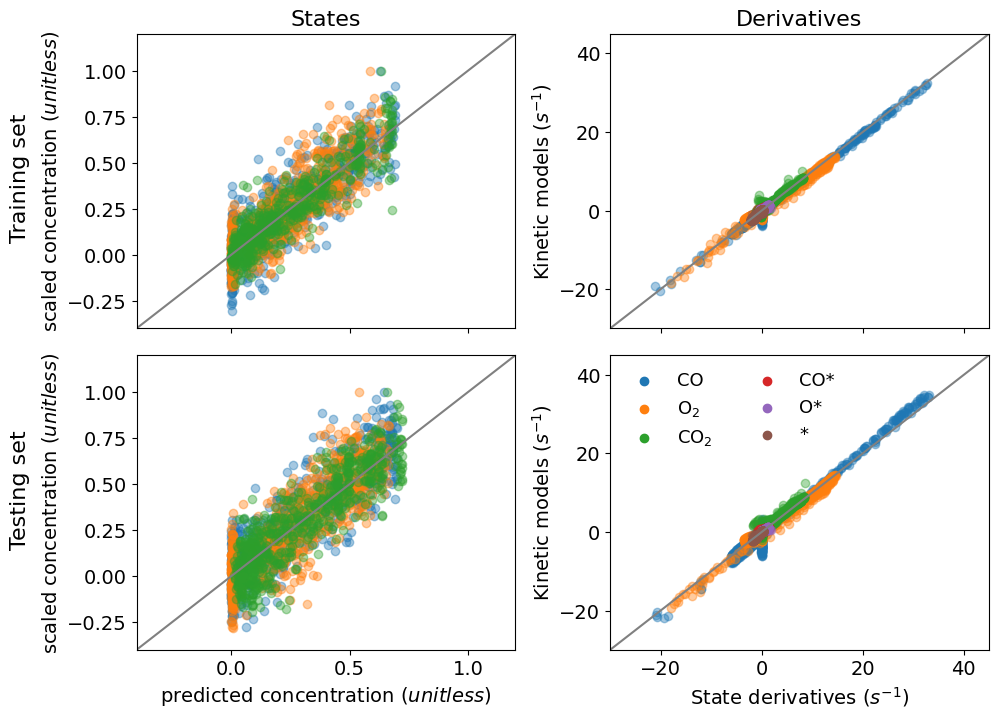

In [39]:
fig = plt.figure(figsize = (11,8))

gs = gridspec.GridSpec(4, 2, figure = fig)
gs.update(wspace=0.25)

ax1 = fig.add_subplot(gs[:2, 0])
# Only have concentration data for gas species
for i in range(n_gas):
    ax1.scatter(batched_state(nn_params_inv, t_input)[:,i],y_train.T[:,i]/y_train_scale[i], 
                color = 'C{}'.format(i), alpha = 0.4)
ax1.set(xlim=(-0.4, 1.2), ylim=(-0.4, 1.2))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="-", c = '.5')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_title('States', fontsize = 16)
ax1.set_ylabel('scaled concentration $(unitless)$')

ax2 = fig.add_subplot(gs[2:, 0], sharex = ax1)
for i in range(n_gas):
    ax2.scatter(batched_state(nn_params_inv, t_input_test)[:,i],y_test.T[:,i]/y_test_scale[i], 
                color = 'C{}'.format(i), alpha = 0.4)
ax2.set(xlim=(-0.4, 1.2), ylim=(-0.4, 1.2))
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="-", c = '.5')
ax2.set_xlabel('predicted concentration $(unitless)$')
ax2.set_ylabel('scaled concentration $(unitless)$')

ax3 = fig.add_subplot(gs[:2, 1])
for i in range(n_species):
    ax3.scatter((diff_state(nn_params_inv,t_input) / np.exp(t_input[:,0:1]))[:,i],
            batched_model([batched_state(nn_params_inv,t_input),t_input], model_params_inv, net_flux_train)[:,i] / data_scale[i],
               color = 'C{}'.format(i), alpha = 0.4)
ax3.set(xlim=(-30, 45), ylim=(-30, 45))
ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="-", c = '.5')
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_title('Derivatives', fontsize = 16)
ax3.set_ylabel('Kinetic models $(s^{-1})$')

ax4 = fig.add_subplot(gs[2:, 1], sharex = ax3)
for i in range(n_species):
    ax4.scatter((diff_state(nn_params_inv,t_input_test)/ np.exp(t_input_test[:,0:1]))[:,i],
        batched_model([batched_state(nn_params_inv,t_input_test),t_input_test], model_params_inv, net_flux_test)[:,i] /data_test_scale[i],
               color = 'C{}'.format(i), alpha = 0.4)
ax4.set(xlim=(-30, 45), ylim=(-30, 45))
ax4.plot(ax4.get_xlim(), ax4.get_ylim(), ls="-", c = '.5')
leg = ax4.legend(['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*','*'], ncol = 2,  prop={'size': 13}, frameon = False)
ax4.set_xlabel('State derivatives $(s^{-1})$')
ax4.set_ylabel('Kinetic models $(s^{-1})$')

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.text(0.01, 0.7, 'Training set', va='center', fontsize = 16, rotation='vertical')

In [172]:
def error_wrt_params(p):
    errs_list = errors_inv([nn_params_inv, p], conc_inv, net_flux_train, uptake_train)
    alpha_factor = np.array([[1e3], [1e3],[1e3],[2]])
    loss = np.array([(errs_list[i]/alpha_factor[i]).mean() for i in range(len(alpha_factor))]).mean()
    
    return loss
hessian_func = jit(hessian(error_wrt_params))

# Assuming 'model_params' holds the value of the parameters at the optimum,
# calculate the Hessian matrix
hessian_matrix = hessian_func(model_params)

# # Inverting the Hessian gives us the covariance matrix
covariance_matrix = np.linalg.inv(np.array(hessian_matrix))[0][0]

# # The standard deviations are the square roots of the diagonal elements of the covariance matrix
standard_deviations = np.sqrt(np.diag(covariance_matrix))

standard_deviations

Array([0.24181838, 0.33424296, 0.00813729, 0.18298266, 0.05358233,
       0.52107784], dtype=float64)

/var/tmp/pbs.1678107.sawtoothpbs/ipykernel_71140/2894678756.py:29: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = fig.legend(['_nolegend_', '_nolegend_', '_nolegend_', '$CO$', '$O_2$', '$CO_2$'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)


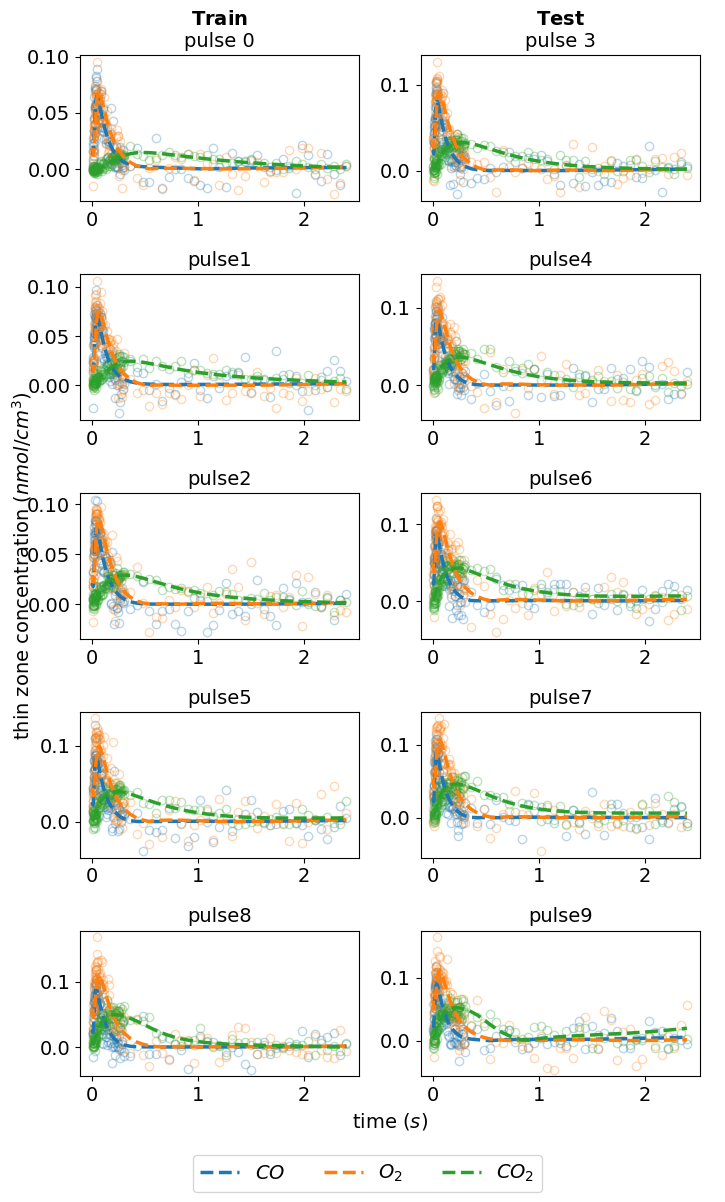

In [43]:
fig, axs = plt.subplots(5,2, figsize=(8, 12), tight_layout = True)

fig.add_subplot(111, frameon=False)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('time $(s)$')
plt.ylabel('thin zone concentration $(nmol/cm^3)$')

for n in range(len(pulse_train)):
    axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]), (y_train.T)[n_p*n:n_p*(n+1),:n_gas],'o',
                  alpha = 0.3, ms = 6, markerfacecolor = "None")
    axs[n, 0].set_prop_cycle(None)
    axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]),batched_state(nn_params_inv, t_input)[n_p*n:n_p*(n+1),:n_gas]*y_train_scale,'--',\
                      linewidth = 2.5)
    axs[n, 0].set_title('pulse' + str(int(pulse_train[n])))
axs[0,0].set_title(r'$\bf{Train}$' + '\n'+'pulse ' + str(pulse_train[0]))

for n in range(len(pulse_test)):
    axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]), (y_test.T)[n_p*n:n_p*(n+1),:n_gas], 'o',
                  alpha = 0.3, ms = 6, markerfacecolor = "None")
    axs[n, 1].set_prop_cycle(None)
    axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]),batched_state(nn_params_inv, t_input_test)[n_p*n:n_p*(n+1),:n_gas]*y_train_scale,'--',\
                      linewidth = 2.5)
    axs[n, 1].set_title('pulse' + str(int(pulse_test[n])))
axs[0,1].set_title(r'$\bf{Test}$' + '\n'+'pulse ' + str(pulse_test[0]))

    
leg = fig.legend(['_nolegend_', '_nolegend_', '_nolegend_', '$CO$', '$O_2$', '$CO_2$'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)

/var/tmp/pbs.1678107.sawtoothpbs/ipykernel_71140/1476517044.py:27: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = fig.legend(['_nolegend_', 'CO*', '_nolegend_', 'O*', '_nolegend_', '*'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)


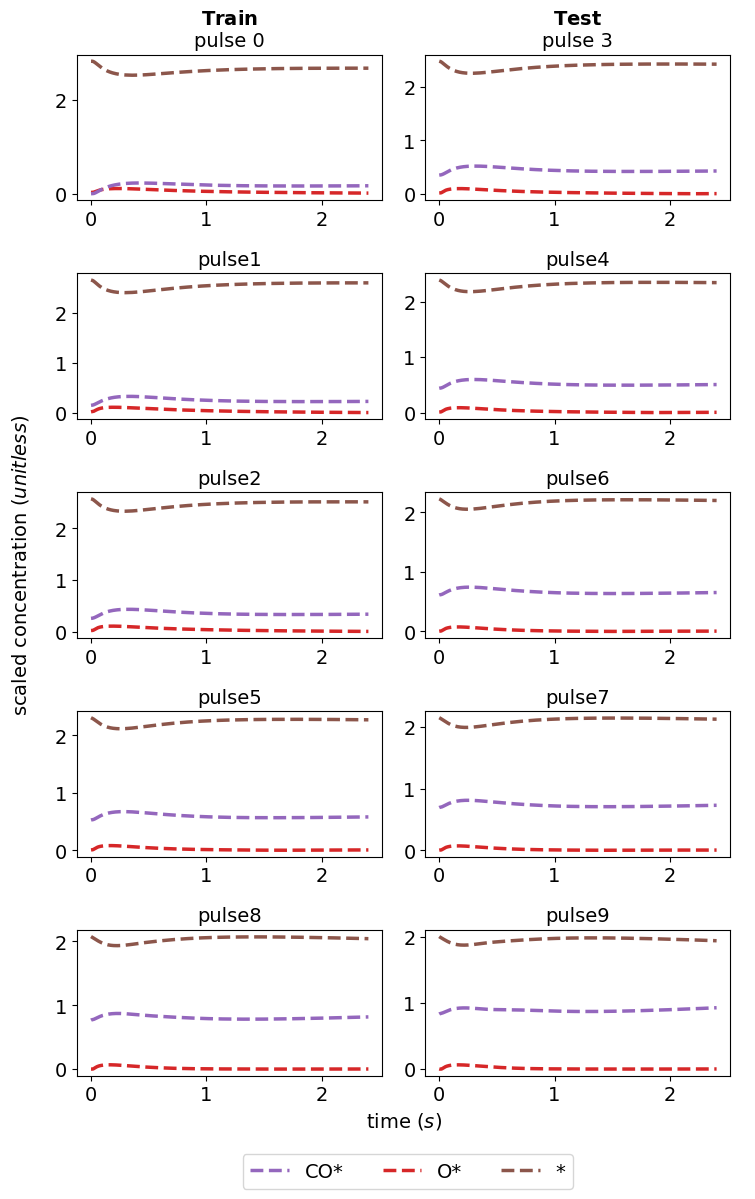

In [49]:
fig, axs = plt.subplots(5,2, figsize=(8, 12), tight_layout = True)

fig.add_subplot(111, frameon=False)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('time $(s)$')
plt.ylabel('scaled concentration $(unitless)$')

for n in range(len(pulse_train)):
    for i in range(n_gas,n_species):
        axs[n, 0].plot(np.exp(t_train[n_p*n:n_p*(n+1)]),batched_state(nn_params, t_input)[n_p*n:n_p*(n+1),i],'--',\
                      color = 'C{}'.format(i), linewidth = 2.5)
        
        axs[n, 0].set_title('pulse' + str(int(pulse_train[n])))
axs[0,0].set_title(r'$\bf{Train}$' + '\n'+'pulse ' + str(pulse_train[0]))

for n in range(len(pulse_test)):
    for i in range(n_gas,n_species):
        axs[n, 1].plot(np.exp(t_test[n_p*n:n_p*(n+1)]),batched_state(nn_params, t_input_test)[n_p*n:n_p*(n+1),i],'--',\
                      color = 'C{}'.format(i), linewidth = 2.5)
        axs[n, 1].set_title('pulse' + str(int(pulse_test[n])))
axs[0,1].set_title(r'$\bf{Test}$' + '\n'+'pulse ' + str(pulse_test[0]))

leg = fig.legend(['_nolegend_', 'CO*', '_nolegend_', 'O*', '_nolegend_', '*'], ncol = 3, bbox_to_anchor=(0.77, 0.03), frameon = True)

In [5]:
np.savez('./results/multi_prac', data = {'nn_params' :nn_params_inv, 'model_params': model_params_inv})